# Tomato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Importing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Constants

In [2]:
IMAGE_SIZE = 256      
CHANNELS=3
BATCH_SIZE = 32

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato",                         # directory name
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)  # Found 16011 files belonging to 10 classes.

Found 9104 files belonging to 10 classes.


In [4]:
len(dataset)                          # images are in 501 batch of each 30 {  30*534 = 16011 approx}

285

### Visualization

In [5]:
class_names = dataset.class_names            # folder class names 
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

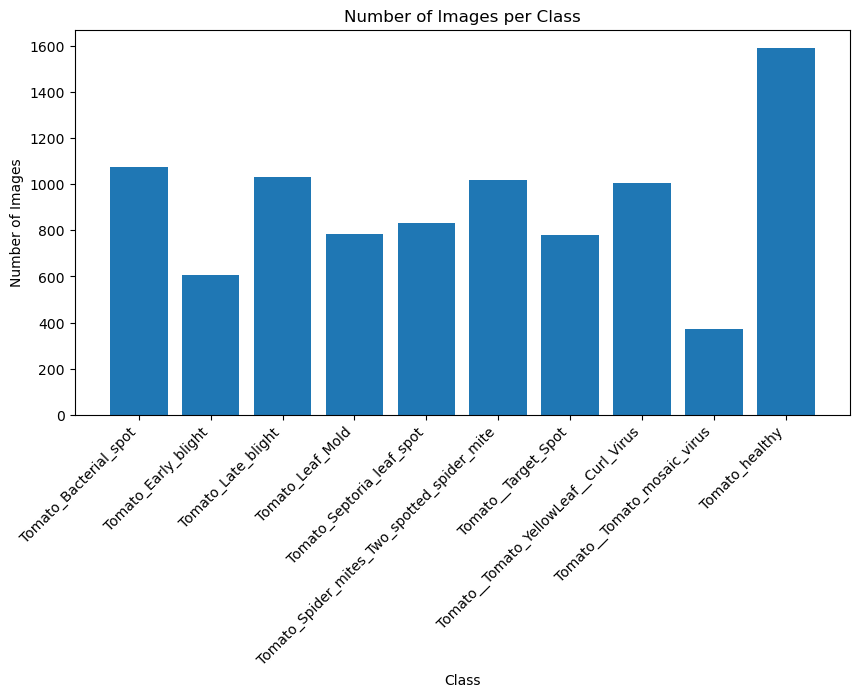

In [6]:
# Count the number of images per class
num_images_per_class = [0] * len(class_names)
for images, labels in dataset:
    for label in labels:
        num_images_per_class[label] += 1

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(class_names, num_images_per_class)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)       #(    32,      256, 256,3           )        batch has 32 images of shape(256,256 ,3) each
                              #         images     shape of each image

    print(labels_batch.numpy())     # gives classes 0 1 2 of all images in 1st batch of 32

(32, 256, 256, 3)
[5 7 5 6 4 4 9 5 9 8 1 9 9 1 6 5 2 2 2 3 7 6 2 9 9 2 2 9 3 2 8 5]


[[[144. 139. 136.]
  [146. 141. 138.]
  [142. 137. 134.]
  ...
  [173. 168. 165.]
  [177. 172. 169.]
  [176. 171. 168.]]

 [[146. 141. 138.]
  [132. 127. 124.]
  [131. 126. 123.]
  ...
  [178. 173. 170.]
  [179. 174. 171.]
  [177. 172. 169.]]

 [[115. 110. 107.]
  [128. 123. 120.]
  [137. 132. 129.]
  ...
  [176. 171. 168.]
  [173. 168. 165.]
  [169. 164. 161.]]

 ...

 [[133. 129. 130.]
  [117. 113. 114.]
  [127. 123. 124.]
  ...
  [162. 160. 163.]
  [163. 161. 164.]
  [162. 160. 163.]]

 [[130. 126. 127.]
  [120. 116. 117.]
  [135. 131. 132.]
  ...
  [162. 160. 163.]
  [164. 162. 165.]
  [163. 161. 164.]]

 [[126. 122. 123.]
  [125. 121. 122.]
  [143. 139. 140.]
  ...
  [162. 160. 163.]
  [164. 162. 165.]
  [164. 162. 165.]]]


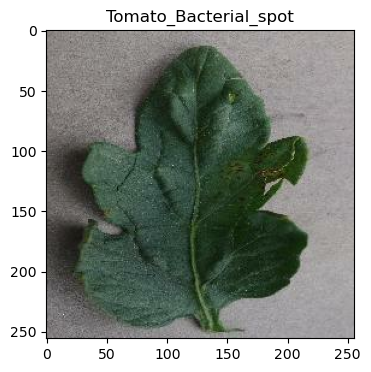

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())      # 1st image of 1st batch 

    plt.figure(figsize=(4, 4))
    plt.title(class_names[labels_batch[0]]) # label of class
    plt.imshow(image_batch[0].numpy().astype("uint8"))      # 1st image of batch
    #plt.axis("off")           to remove measures

More images

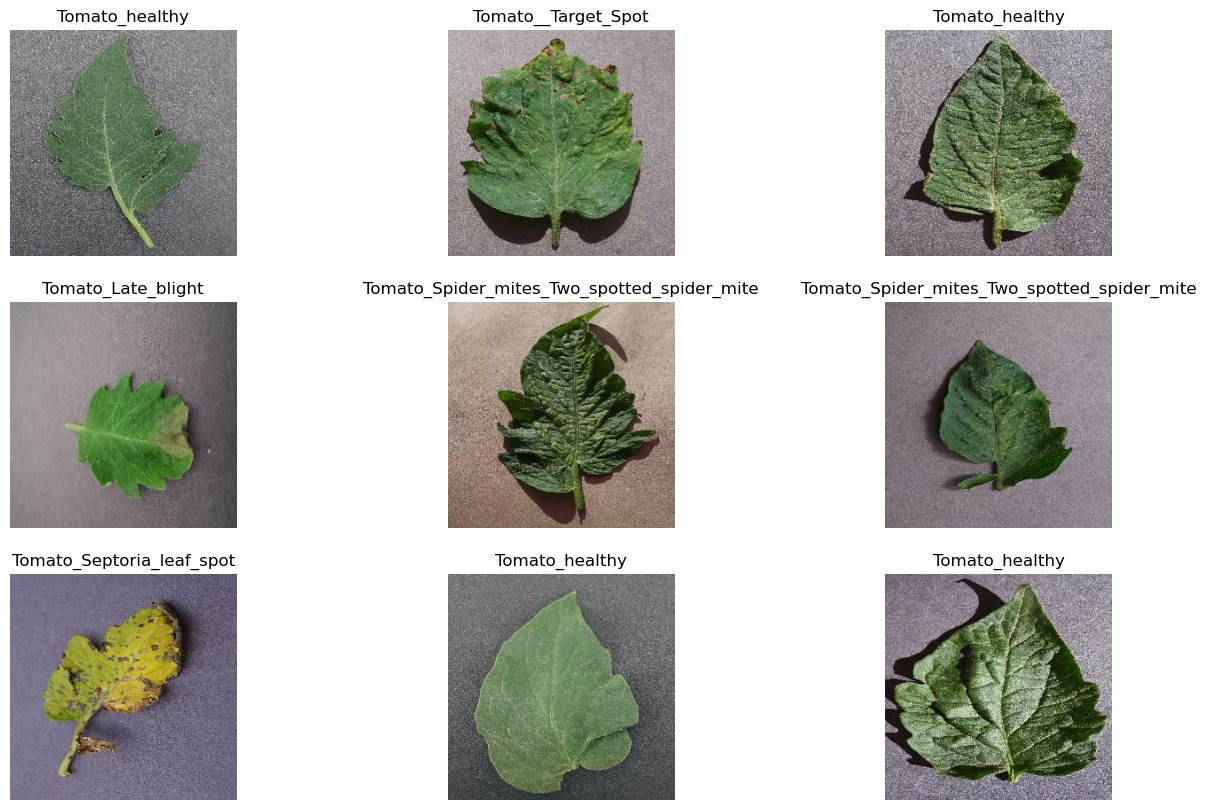

In [9]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
1. 80% training
2. 10% validation for each epoch
3. 10% test

In [10]:
# fn for above splitting
def data_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds,test_ds = data_splitting(dataset)       #batches splitting


In [12]:
len(train_ds)

228

In [13]:
len(val_ds)

28

In [14]:
len(test_ds)

29

### Cache, Shuffle, and Prefetch the Dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

In [16]:
data_augmentation1 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
data_augmentation2 = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.8),
])

Applying Data Augmentation to Train Dataset

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation1(x, training=True), y)        ).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 function

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation2(x, training=True), y)        ).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 function

### Resize and rescale

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Model Architecture

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)  #4


model = models.Sequential(
    [ 
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 127, 127, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 63, 63, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
EPOCHS=50
with tf.device('/GPU:0'):
    epoch_details = model.fit(
                            train_ds,
                            batch_size=BATCH_SIZE,
                            validation_data=val_ds,
                            verbose=1,
                            epochs=EPOCHS,
                        )

Epoch 1/50
228/228 [==============================] - 117s 396ms/step - loss: 1.7364 - accuracy: 0.3857 - val_loss: 1.4986 - val_accuracy: 0.4977
Epoch 2/50
228/228 [==============================] - 68s 299ms/step - loss: 1.1415 - accuracy: 0.5978 - val_loss: 0.8216 - val_accuracy: 0.7125
Epoch 3/50
228/228 [==============================] - 67s 292ms/step - loss: 0.9433 - accuracy: 0.6701 - val_loss: 1.2828 - val_accuracy: 0.6159
Epoch 4/50
228/228 [==============================] - 71s 311ms/step - loss: 0.8379 - accuracy: 0.7113 - val_loss: 1.1038 - val_accuracy: 0.6511
Epoch 5/50
228/228 [==============================] - 75s 326ms/step - loss: 0.7290 - accuracy: 0.7573 - val_loss: 1.1511 - val_accuracy: 0.6625
Epoch 6/50
228/228 [==============================] - 76s 331ms/step - loss: 0.6653 - accuracy: 0.7687 - val_loss: 1.2856 - val_accuracy: 0.6136
Epoch 7/50
228/228 [==============================] - 77s 339ms/step - loss: 0.6606 - accuracy: 0.7721 - val_loss: 1.1146 - val_a

In [24]:
model.evaluate(test_ds)

29/29 [==============================] - 31s 102ms/step - loss: 0.2643 - accuracy: 0.9310


[0.264316201210022, 0.931034505367279]

### Accuracy and Loss Curves

In [25]:
epoch_details.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
epoch_details.history['loss'][:5] # show loss for first 5 epochs

[1.7363792657852173,
 1.1414921283721924,
 0.9433265924453735,
 0.837873637676239,
 0.7290018200874329]

In [27]:
acc = epoch_details.history['accuracy']
val_acc = epoch_details.history['val_accuracy']

loss = epoch_details.history['loss']
val_loss = epoch_details.history['val_loss']

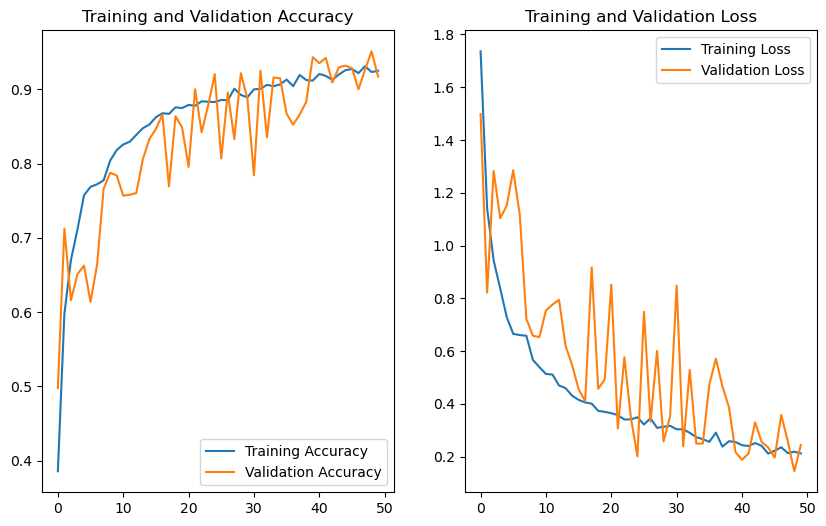

In [28]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Function for Prediction

In [30]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

##### Prediction on sample images

1/1 [==============================] - 0s 15ms/step


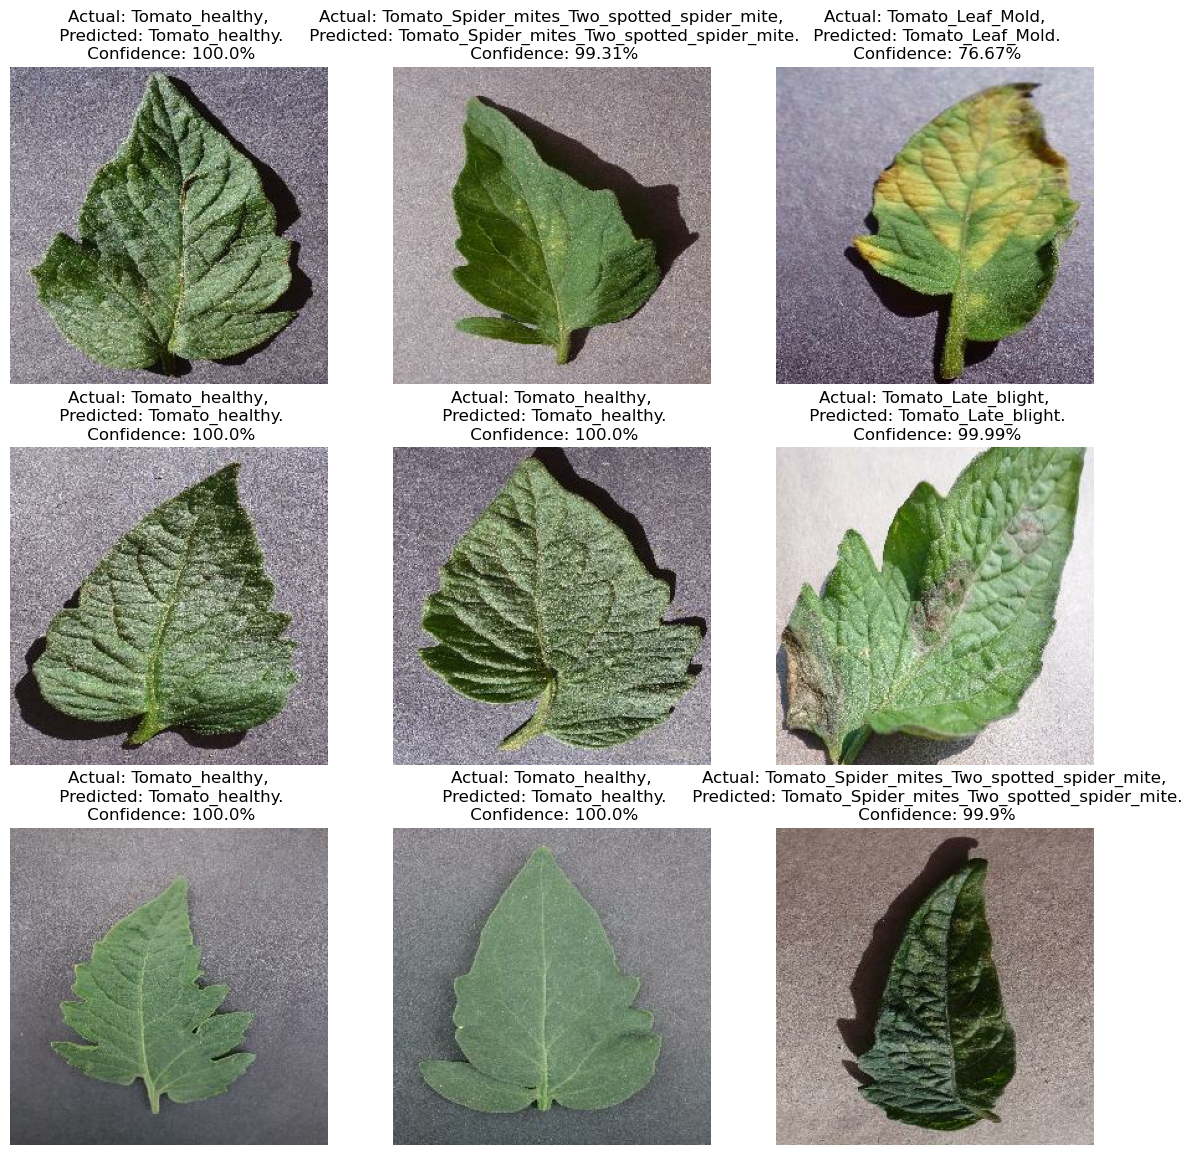

In [31]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [36]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [38]:
model.save("../tomato.h5")